# PPO Example

## Proximal Policy Optimization from Towards Data Science
## By Yuki Minai
### https://medium.com/@ym1942/proximal-policy-optimization-tutorial-f722f23beb83

In [1]:
# %pip install pandas[pyarrow] numpy==1.26.4 torch gymnasium tqdm seaborn scikit-learn scipy

In [2]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=(32, 32, 16)):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()
        
    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy
        
        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)

In [4]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1, -1, -1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma * G
        Gs.insert(0, G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        V = value_net(states).to(device)
        
        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)
                
        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A, 1, B) to select columns from A based on indices in B
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in clipped loss
        full_loss = ratios * A_k
        clipped_loss = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(full_loss, clipped_loss)).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net

  0%|                                                                                                                                          | 0/5 [00:00<?, ?it/s]C:\Users\lando\AppData\Local\pypoetry\Cache\virtualenvs\rubiks-X7avAL8r-py3.9\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is 14.3 with std of 5.070502933634888.
Episode: 50
The avg. test reward for episode 50 is 10.55 with std of 1.8020821290940099.
Episode: 100
The avg. test reward for episode 100 is 62.05 with std of 18.499932432309045.
Episode: 150
The avg. test reward for episode 150 is 127.8 with std of 31.42705840513872.
Episode: 200
The avg. test reward for episode 200 is 500.0 with std of 0.0.
Episode: 250
The avg. test reward for episode 250 is 500.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 499.15 with std of 3.705064102009572.
Episode: 350
The avg. test reward for episode 350 is 500.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 500.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 500.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 500.0 with std of 0.0.
Episode: 550
The avg. test reward for episode 550 is 500.0 with std of 0.0.
Episode: 600
The avg. 

 20%|█████████████████████████▊                                                                                                       | 1/5 [06:09<24:39, 369.98s/it]

Episode: 0
The avg. test reward for episode 0 is 21.25 with std of 10.039297784207818.
Episode: 50
The avg. test reward for episode 50 is 26.75 with std of 13.106773058232145.
Episode: 100
The avg. test reward for episode 100 is 32.2 with std of 6.071243694664216.
Episode: 150
The avg. test reward for episode 150 is 105.25 with std of 23.980982048281508.
Episode: 200
The avg. test reward for episode 200 is 167.7 with std of 14.809118812407442.
Episode: 250
The avg. test reward for episode 250 is 378.35 with std of 35.53487723350117.
Episode: 300
The avg. test reward for episode 300 is 493.3 with std of 12.393950137062841.
Episode: 350
The avg. test reward for episode 350 is 500.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 500.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 500.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 500.0 with std of 0.0.
Episode: 550
The avg. test reward for episode 550 is 481.6 with st

 40%|███████████████████████████████████████████████████▌                                                                             | 2/5 [11:53<17:43, 354.56s/it]

Episode: 0
The avg. test reward for episode 0 is 20.35 with std of 19.30097147814068.
Episode: 50
The avg. test reward for episode 50 is 21.8 with std of 8.1706792863262.
Episode: 100
The avg. test reward for episode 100 is 35.7 with std of 21.20400905489337.
Episode: 150
The avg. test reward for episode 150 is 187.45 with std of 17.62235795800324.
Episode: 200
The avg. test reward for episode 200 is 410.9 with std of 55.16058375325627.
Episode: 250
The avg. test reward for episode 250 is 490.4 with std of 41.845429857990474.
Episode: 300
The avg. test reward for episode 300 is 387.5 with std of 95.97473625908017.
Episode: 350
The avg. test reward for episode 350 is 488.6 with std of 19.990997974088238.
Episode: 400
The avg. test reward for episode 400 is 475.7 with std of 49.09388964015786.
Episode: 450
The avg. test reward for episode 450 is 497.4 with std of 11.33313725320575.
Episode: 500
The avg. test reward for episode 500 is 331.4 with std of 90.52093680469729.
Episode: 550
The 

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 3/5 [17:45<11:46, 353.19s/it]

Episode: 0
The avg. test reward for episode 0 is 20.1 with std of 12.299999999999999.
Episode: 50
The avg. test reward for episode 50 is 15.4 with std of 3.2465366161495854.
Episode: 100
The avg. test reward for episode 100 is 78.65 with std of 28.822343763129325.
Episode: 150
The avg. test reward for episode 150 is 45.2 with std of 10.419213022104886.
Episode: 200
The avg. test reward for episode 200 is 159.75 with std of 60.84149488630272.
Episode: 250
The avg. test reward for episode 250 is 208.9 with std of 32.44518454254807.
Episode: 300
The avg. test reward for episode 300 is 256.65 with std of 66.7654663729686.
Episode: 350
The avg. test reward for episode 350 is 383.05 with std of 64.2763370144877.
Episode: 400
The avg. test reward for episode 400 is 424.85 with std of 36.744081156017494.
Episode: 450
The avg. test reward for episode 450 is 481.55 with std of 32.14572288812308.
Episode: 500
The avg. test reward for episode 500 is 500.0 with std of 0.0.
Episode: 550
The avg. tes

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4/5 [22:52<05:35, 335.03s/it]

Episode: 0
The avg. test reward for episode 0 is 16.85 with std of 7.894776754285076.
Episode: 50
The avg. test reward for episode 50 is 31.9 with std of 18.239791665476883.
Episode: 100
The avg. test reward for episode 100 is 305.95 with std of 79.98029444807014.
Episode: 150
The avg. test reward for episode 150 is 413.75 with std of 49.35876315306128.
Episode: 200
The avg. test reward for episode 200 is 484.85 with std of 48.496675143766296.
Episode: 250
The avg. test reward for episode 250 is 483.25 with std of 50.35958200779669.
Episode: 300
The avg. test reward for episode 300 is 355.7 with std of 56.76979830860772.
Episode: 350
The avg. test reward for episode 350 is 500.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 484.8 with std of 47.96102584390788.
Episode: 450
The avg. test reward for episode 450 is 420.8 with std of 121.307707916686.
Episode: 500
The avg. test reward for episode 500 is 485.2 with std of 47.238331892648375.
Episode: 550
The avg. tes

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [28:53<00:00, 346.64s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

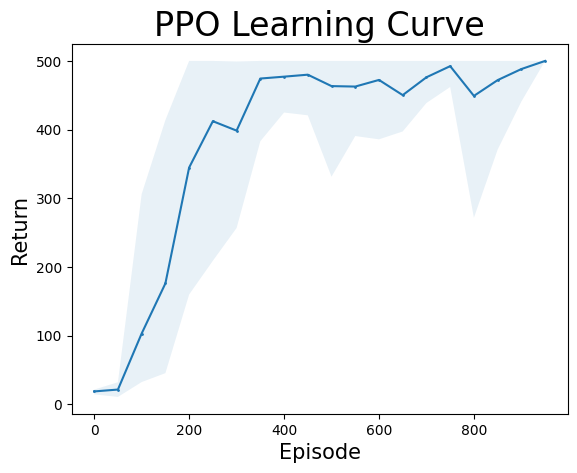

In [5]:
# Define parameter values
env_name = 'CartPole-v1'
num_train_ite = 1000
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite // eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4

policy_lr = 5e-4 # policy network's learning rate 
baseline_lr = 1e-4 # value network's learning rate
 
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax(dim=nA))
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

In [6]:
def compute_Gs_per_episode(batch_rews, gamma):
    # The rewards-to-go (rtg) per episode per batch to return
    batch_rtgs = []
    
    # Iterate through each episode backwards to maintain same order in batch_rtgs
    for ep_rews in reversed(batch_rews):
        discounted_reward = 0 # Discounted reward so far
        
        for rew in reversed(ep_rews):
            discounted_reward = rew + discounted_reward * gamma
            batch_rtgs.insert(0, discounted_reward)
            
    # Convert the rewards-to-go into a tensor
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

    return batch_rtgs


def generate_multiple_episodes(env, policy_net, max_batch_size=500):
    """
    Generates episodes by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    i = 0
    
    while i < max_batch_size:
        state, _ = env.reset()
        reward_per_epi = []
        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
            # action = np.argmax(probs.detach().numpy()) # greedy
            
            # compute the log_prob to use this in parameter update
            log_prob = torch.log(probs.squeeze(0)[action])
            
            # append values
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            
            # take a selected action
            state, reward, terminated, truncated, _ = env.step(action)
            reward_per_epi.append(reward)
            
            i += 1

            if terminated | truncated:
                break
        rewards.append(reward_per_epi)
        
    return states, actions, rewards, log_probs


def train_PPO_multi_epi(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, max_batch_size=100, entropy_coef=0.1, normalize_ad=True, add_entropy=True):
    """
    Trains the policy network using PPO with some modeling techniques
    """

    # Generate episodes with the current policy network
    states, actions, rewards, log_probs = generate_multiple_episodes(env, policy_net, max_batch_size=max_batch_size)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step in each episode
    Gs = compute_Gs_per_episode(rewards, gamma).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
    if normalize_ad:
        A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # Normalize advantages
        
    for _ in range(num_epochs):
        V = value_net(states).to(device)
        
        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)
                
        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, min=(1 - clip_val), max=(1 + clip_val)) * A_k
        
        # Caluculate entropy
        entropy = 0
        if add_entropy:
            entropy = torch.distributions.Categorical(probs).entropy()
            entropy = torch.tensor([[e] for e in entropy])
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2) - entropy_coef * entropy).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()        
        
    return policy_net, value_net

  0%|                                                                                                                                          | 0/5 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 14.45 with std of 6.094874896173013.
Episode: 50
The avg. test reward for episode 50 is 205.75 with std of 81.20275549511851.
Episode: 100
The avg. test reward for episode 100 is 278.05 with std of 129.65549544851544.
Episode: 150
The avg. test reward for episode 150 is 194.9 with std of 48.04882933017203.
Episode: 200
The avg. test reward for episode 200 is 368.6 with std of 100.49696512830623.
Episode: 250
The avg. test reward for episode 250 is 480.65 with std of 54.611605909366915.
Episode: 300
The avg. test reward for episode 300 is 461.6 with std of 81.36301371016194.
Episode: 350
The avg. test reward for episode 350 is 500.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 500.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 500.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 434.35 with std of 133.60923433655324.
Episode: 550
The avg. test reward for episode 550 

 20%|█████████████████████████▊                                                                                                       | 1/5 [06:20<25:22, 380.72s/it]

Episode: 0
The avg. test reward for episode 0 is 17.75 with std of 7.231009611388993.
Episode: 50
The avg. test reward for episode 50 is 182.35 with std of 48.60378071714175.
Episode: 100
The avg. test reward for episode 100 is 318.25 with std of 99.37397798216594.
Episode: 150
The avg. test reward for episode 150 is 499.55 with std of 1.9615045245933027.
Episode: 200
The avg. test reward for episode 200 is 126.25 with std of 22.50749875041649.
Episode: 250
The avg. test reward for episode 250 is 148.7 with std of 97.62791608961034.
Episode: 300
The avg. test reward for episode 300 is 83.3 with std of 18.259518065929342.
Episode: 350
The avg. test reward for episode 350 is 76.55 with std of 11.079147079085104.
Episode: 400
The avg. test reward for episode 400 is 467.9 with std of 58.6633616493293.
Episode: 450
The avg. test reward for episode 450 is 221.05 with std of 108.8262261589549.
Episode: 500
The avg. test reward for episode 500 is 455.05 with std of 121.05555542807609.
Episode:

 40%|███████████████████████████████████████████████████▌                                                                             | 2/5 [11:46<17:25, 348.58s/it]

Episode: 0
The avg. test reward for episode 0 is 20.35 with std of 11.394187114489563.
Episode: 50
The avg. test reward for episode 50 is 211.3 with std of 112.88671312426452.
Episode: 100
The avg. test reward for episode 100 is 102.7 with std of 29.705386716890253.
Episode: 150
The avg. test reward for episode 150 is 448.8 with std of 62.81369277474458.
Episode: 200
The avg. test reward for episode 200 is 93.45 with std of 24.74565618447003.
Episode: 250
The avg. test reward for episode 250 is 296.65 with std of 83.03810872123714.
Episode: 300
The avg. test reward for episode 300 is 341.2 with std of 114.01692856764735.
Episode: 350
The avg. test reward for episode 350 is 476.4 with std of 45.761774441120615.
Episode: 400
The avg. test reward for episode 400 is 421.35 with std of 127.51010744250826.
Episode: 450
The avg. test reward for episode 450 is 271.75 with std of 63.23201325278201.
Episode: 500
The avg. test reward for episode 500 is 256.75 with std of 101.39175262317937.
Episo

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 3/5 [17:38<11:39, 349.80s/it]

Episode: 0
The avg. test reward for episode 0 is 25.05 with std of 10.327027645939559.
Episode: 50
The avg. test reward for episode 50 is 107.15 with std of 43.72559319208831.
Episode: 100
The avg. test reward for episode 100 is 176.45 with std of 42.704185977489374.
Episode: 150
The avg. test reward for episode 150 is 169.75 with std of 35.31554190437972.
Episode: 200
The avg. test reward for episode 200 is 179.95 with std of 29.152144003486264.
Episode: 250
The avg. test reward for episode 250 is 147.45 with std of 23.45095946864435.
Episode: 300
The avg. test reward for episode 300 is 409.85 with std of 98.63684656354337.
Episode: 350
The avg. test reward for episode 350 is 364.75 with std of 122.77331754090544.
Episode: 400
The avg. test reward for episode 400 is 490.5 with std of 41.4095399636364.
Episode: 450
The avg. test reward for episode 450 is 476.95 with std of 62.202471815837036.
Episode: 500
The avg. test reward for episode 500 is 442.4 with std of 110.74989841981798.
Epi

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4/5 [23:23<05:48, 348.09s/it]

Episode: 0
The avg. test reward for episode 0 is 21.1 with std of 10.926573113286707.
Episode: 50
The avg. test reward for episode 50 is 321.55 with std of 131.91757843441488.
Episode: 100
The avg. test reward for episode 100 is 305.15 with std of 108.81602593368314.
Episode: 150
The avg. test reward for episode 150 is 102.25 with std of 20.517979920060355.
Episode: 200
The avg. test reward for episode 200 is 298.15 with std of 68.44653022615536.
Episode: 250
The avg. test reward for episode 250 is 450.05 with std of 78.67494836350387.
Episode: 300
The avg. test reward for episode 300 is 421.9 with std of 44.71565721310602.
Episode: 350
The avg. test reward for episode 350 is 355.15 with std of 129.84924913144474.
Episode: 400
The avg. test reward for episode 400 is 500.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 500.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 458.25 with std of 73.42470633240558.
Episode: 550
The avg. test reward

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [28:54<00:00, 346.99s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

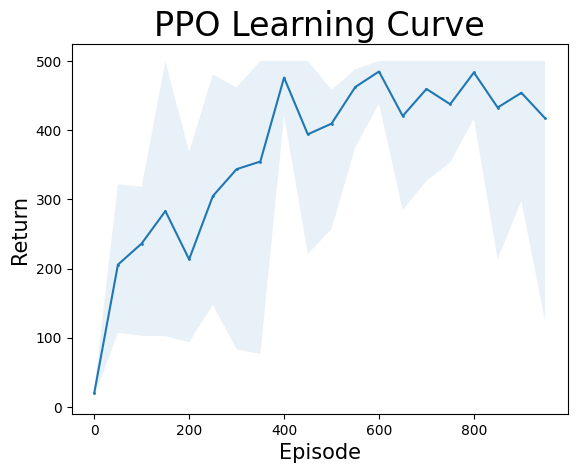

In [7]:
# Define parameter values
returns = np.zeros((num_seeds, eval_epi_index))
max_batch_size = 100
entropy_coef = 0.1
normalize_ad = True
add_entropy = True

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO_multi_epi(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma, max_batch_size=max_batch_size, entropy_coef=entropy_coef, normalize_ad=normalize_ad, add_entropy=add_entropy)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

    
# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

In [6]:
# %pip install numpy torch --force-reinstall

## Let's Code Proximal Policy Optimization
## Edan Meyer
## https://www.youtube.com/watch?v=HR8kQMTO8bk&list=WL&index=29

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.distributions.categorical import Categorical

sns.set()

In [2]:
DEVICE = 'cpu'

In [21]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size, action_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size),
            # nn.Softmax(),
        )
        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def value(self, obs):
        """Predict value of the current state"""
        return self.value_layers(self.shared_layers(obs))

    def policy(self, obs):
        """Generate probabilities of taking certain actions from the current state"""
        return self.policy_layers(self.shared_layers(obs))

    def forward(self, obs):
        """Get both policy logits and current state value from the actor-critic model"""
        z = self.shared_layers(obs)
        logits = self.policy_layers(z)
        value = self.value_layers(z)
        return logits, value

In [22]:
class PPOTrainer:
    def __init__(
            self,
            ac,
            clip_val=0.2,
            target_kl_div=0.01,
            max_policy_iters=80,
            max_value_iters=80,
            policy_lr=3e-4,
            value_lr=1e-2):
        self.ac = ac
        self.clip_val = clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_iters = max_policy_iters
        self.max_value_iters = max_value_iters

        policy_params = list(self.ac.shared_layers.parameters()) + list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)
        
        value_params = list(self.ac.shared_layers.parameters()) + list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        for _ in range(self.max_policy_iters):
            self.policy_optim.zero_grad()
    
            new_logits = Categorical(logits=self.ac.policy(obs))
            new_log_probs = new_logits.log_prob(acts)
            
            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(1 - self.clip_val, 1 + self.clip_val)
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()
    
            policy_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def train_value(self, obs, rewards):
        for _ in range(self.max_value_iters):
            self.value_optim.zero_grad()
    
            values = self.ac.value(obs)
            mse = ((rewards - values) ** 2).mean()
            mse.backward()
            self.value_optim.step()

In [23]:
def discount_rewards(rewards, gamma=0.99):
    """Blending future rewards into the past"""
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards) - 1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    """Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/pdf/1506.02438
    """
    next_values = rewards[1:] + [0]
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas) - 1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

In [24]:
def rollout(model, env, max_steps=1000):
    ### Create data storage
    train_data = {
        'obs': [],
        'act': [],
        'reward': [],
        'value': [],
        'act_log_prob': [],
    }
    obs, _info = env.reset()

    ep_reward = 0
    for _ in range(max_steps):
        # Get logits and value from the actor-critic
        logits, value = model(torch.tensor([obs], dtype=torch.float32, device=DEVICE))
        
        # Sample an action from the policy logits
        act_distribution = Categorical(logits=logits)
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).item()
        
        # Step the environment forward
        next_obs, reward, finished, truncated, _info = env.step(act.item())

        # Record training data
        for li, item in zip(train_data.values(), (obs, act.item(), reward, value.item(), act_log_prob)):
            li.append(item)

        obs = next_obs
        ep_reward += reward
        if finished:
            break

    train_data['value'] = calculate_gaes(train_data['reward'], train_data['value'])
    # print(train_data)
    return {k: np.array(v) for k, v in train_data.items()}, ep_reward

In [38]:
env = gym.make('CartPole-v0')
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)
train_data, reward = rollout(model, env)

In [39]:
print({k: v.shape for k, v in train_data.items()})

{'obs': (42, 4), 'act': (42,), 'reward': (42,), 'value': (42,), 'act_log_prob': (42,)}


In [41]:
# Training parameters
n_episodes = 60
print_freq = 20

ppo = PPOTrainer(
    model,
    policy_lr=3e-4,
    value_lr=1e-3,
    target_kl_div=2e-2,
    max_policy_iters=40,
    max_value_iters=40)

In [42]:
# Training loop
batch_size = 1024
batch = {
    'obs': np.array([]).reshape(0, *env.observation_space.shape),
    'act': np.array([]),
    'reward': np.array([]),
    'value': np.array([]),
    'act_log_prob': np.array([]),
}
ep_rewards = []
for ep_num in range(n_episodes):
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    # Shuffle (I don't see the purpose of the shuffle unless we were batching multiple episodes together)
    # permute_idx = np.random.permutation(train_data['act'].shape[0])
    
    # Policy data
    # obs = torch.tensor(train_data['obs'][permute_idx], dtype=torch.float32, device=DEVICE)
    # acts = torch.tensor(train_data['act'][permute_idx], dtype=torch.int32, device=DEVICE)
    # gaes = torch.tensor(train_data['value'][permute_idx], dtype=torch.int32, device=DEVICE)
    # act_log_probs = torch.tensor(train_data['act_log_prob'][permute_idx], dtype=torch.int32, device=DEVICE)

    # Value data
    # Make gamma match
    train_data['reward'] = discount_rewards(train_data['reward'])
    # rewards = discount_rewards(train_data['reward'])[permute_idx]
    # rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE)

    # Add to batch
    for k in batch.keys():
        batch[k] = np.concatenate([batch[k], train_data[k]])
    
    # Train model
    if batch['act'].shape[0] >= batch_size:
        print(f"training on batch of size {batch['act'].shape[0]}")

        permute_idx = np.random.permutation(batch['act'].shape[0])
        print(batch['obs'].shape)
        ppo.train_policy(
            torch.tensor(batch['obs'][permute_idx], dtype=torch.float32, device=DEVICE),
            torch.tensor(batch['act'][permute_idx], dtype=torch.int32, device=DEVICE),
            torch.tensor(batch['value'][permute_idx], dtype=torch.int32, device=DEVICE),
            torch.tensor(batch['act_log_prob'][permute_idx], dtype=torch.int32, device=DEVICE))
        ppo.train_value(
            torch.tensor(batch['obs'][permute_idx], dtype=torch.float32, device=DEVICE),
            torch.tensor(batch['reward'][permute_idx], dtype=torch.float32, device=DEVICE),)

        # Empty the replay buffer
        for k in batch.keys():
            batch[k] = batch[k][:0]

    if len(ep_rewards) % print_freq == 0:
        print(f'Episode {ep_num + 1} | Avg. Reward: {np.mean(ep_rewards[-print_freq:]):.2f}')

Episode 20 | Avg. Reward: 22.80
Episode 40 | Avg. Reward: 22.10
training on batch of size 1045
(1045, 4)
Episode 60 | Avg. Reward: 19.65


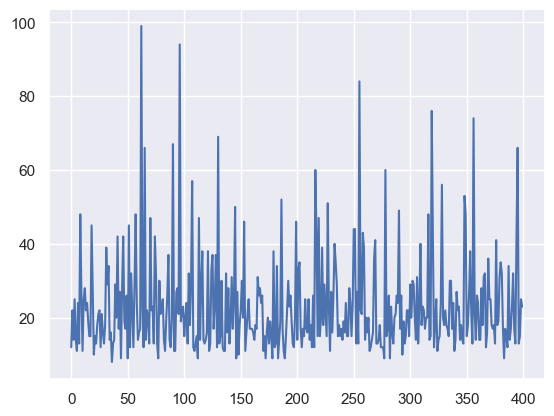

In [171]:
plt.plot(ep_rewards)
plt.show()

# ChatGPT's answer

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Hyperparameters
gamma = 0.99  # discount factor
epsilon_clip = 0.2  # PPO clipping parameter
value_coeff = 0.5   # Weight of value loss
entropy_coeff = 0.01  # Weight of entropy bonus
learning_rate = 0.0003
n_epochs = 10        # Number of epochs to update
batch_size = 64      # Batch size for training

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size=4, output_size=2, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)  # Softmax for action probabilities
        return x

# Define the Value Network
class ValueNetwork(nn.Module):
    def __init__(self, input_size=4, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)  # Single output for state-value estimation
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation since we are predicting a scalar value
        return x

# Define function to compute the advantage (returns - value)
def compute_advantages(rewards, values, gamma=0.99):
    advantages = []
    discount_return = 0
    for r, v in zip(reversed(rewards), reversed(values)):
        discount_return = r + gamma * discount_return
        advantage = discount_return - v
        advantages.insert(0, advantage)
    return torch.tensor(advantages)

# PPO training loop
def ppo_train(policy_net, value_net, optimizer_policy, optimizer_value, states, actions, rewards, old_action_probs):
    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32)
    values0 = value_net(states).squeeze()  # (batch_size, 1) -> (batch_size)
    # Compute advantages
    advantages = compute_advantages(rewards, values0.detach().numpy(), gamma)
    
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    old_action_probs = torch.tensor(old_action_probs, dtype=torch.float32)
    
    # Training for multiple epochs
    for _ in range(n_epochs):
        # Zero out gradients
        optimizer_policy.zero_grad()
        optimizer_value.zero_grad()
        
        # Compute new action probabilities
        new_action_probs = policy_net(states)
        dist = torch.distributions.Categorical(new_action_probs)
        new_log_probs = dist.log_prob(actions)

        # Compute policy ratio
        policy_ratio = torch.exp(new_log_probs - torch.log(old_action_probs))

        # Compute clipped loss
        clipped_ratio = torch.clamp(policy_ratio, 1 - epsilon_clip, 1 + epsilon_clip)
        policy_loss = -torch.min(policy_ratio * advantages, clipped_ratio * advantages).mean()

        # Compute value loss
        values = value_net(states).squeeze()  # (batch_size, 1) -> (batch_size)
        value_loss = value_coeff * (rewards - values).pow(2).mean()

        # Compute entropy bonus (for exploration)
        entropy_loss = -entropy_coeff * dist.entropy().mean()

        # Combine losses
        total_loss = policy_loss + value_loss + entropy_loss

        # Backpropagate for policy network        
        total_loss.backward(retain_graph=True)  # Retain graph for value net update
        optimizer_policy.step()

        
        values = value_net(states).squeeze()  # (batch_size, 1) -> (batch_size)
        value_loss = value_coeff * (rewards - values).pow(2).mean()
        value_loss.backward()  # Separate backward pass for value network
        optimizer_value.step()


# Example of how to use it in training
policy_net = PolicyNetwork()
value_net = ValueNetwork()

optimizer_policy = optim.Adam(policy_net.parameters(), lr=learning_rate)
optimizer_value = optim.Adam(value_net.parameters(), lr=learning_rate)

# Dummy example data (in practice, this would come from interactions with the environment)
states = np.random.rand(100, 4)  # 100 timesteps, 4 input features
actions = np.random.randint(0, 2, size=100)  # 100 actions (binary)
rewards = np.random.rand(100)  # 100 rewards
old_action_probs = np.random.rand(100)  # 100 old action probabilities

# Call the PPO training function
ppo_train(policy_net, value_net, optimizer_policy, optimizer_value, states, actions, rewards, old_action_probs)


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)
    
    def forward(self, x):
        return self.fc1(x)

# Create the model, loss function, and optimizer
model = SimpleNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Dummy data
inputs = torch.tensor([[1.0, 2.0], [2.0, 3.0]])
targets = torch.tensor([[0.0, 1.0], [1.0, 0.0]])

# Training loop
for epoch in range(5):  # Number of epochs
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = criterion(outputs, targets)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


Epoch 1, Loss: 2.265209197998047
Epoch 2, Loss: 1.8746813535690308
Epoch 3, Loss: 1.5577667951583862
Epoch 4, Loss: 1.3005788326263428
Epoch 5, Loss: 1.0918511152267456
